# SQLAlchemy Challenge

### Dependencies and Setup

In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
sns.set()
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6
import numpy as np
import pandas as pd
import datetime as dt
pd.set_option('display.max_colwidth', 40)
pd.options.display.float_format = '{:,.2f}'.format

## Database Connection

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import Session
from sqlalchemy import *

In [3]:
# reflect an existing database into a new model
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Use the Base class to reflect the database tables
Base = automap_base()
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

## Datasets Overview

In [15]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)
for measure in session.query(measurement).limit(10):
    print(measure.id, measure.station, measure.date, measure.prcp, measure.tobs)

1 USC00519397 2010-01-01 0.08 65.0
2 USC00519397 2010-01-02 0.0 63.0
3 USC00519397 2010-01-03 0.0 74.0
4 USC00519397 2010-01-04 0.0 76.0
5 USC00519397 2010-01-06 None 73.0
6 USC00519397 2010-01-07 0.06 70.0
7 USC00519397 2010-01-08 0.0 64.0
8 USC00519397 2010-01-09 0.0 68.0
9 USC00519397 2010-01-10 0.0 73.0
10 USC00519397 2010-01-11 0.01 64.0


In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
table_1 = inspector.get_table_names()[0]
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns(table_1)
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
measurement = pd.read_sql('measurement', engine)
print(measurement.shape)
measurement.head()

(19550, 5)


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.00
1,2,USC00519397,2010-01-02,0.00,63.00
2,3,USC00519397,2010-01-03,0.00,74.00
3,4,USC00519397,2010-01-04,0.00,76.00
4,5,USC00519397,2010-01-06,nan,73.00


In [7]:
station = pd.read_sql('station', engine)
print(station.shape)
station.head()

(9, 6)


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27,-157.82,3.00
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42,-157.80,14.60
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52,-157.84,7.00
3,4,USC00517948,"PEARL CITY, HI US",21.39,-157.98,11.90
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.50,-158.01,306.60


## Exploratory Climate Analysis

In [32]:
# Design a query to retrieve the last year and 1 month of previous year of precipitation data
# Use the session to query using date type
date_conv = func.date(measurement.date, type_=Date)
stmt = session.query(func.date(measurement.date), measurement.prcp).\
                    filter((extract('year', date_conv) == 2017) |
                           ((extract('year', date_conv) == 2016) &
                           (extract('month', date_conv) == 12))).\
                    order_by(measurement.date.desc()).statement
data = pd.read_sql_query(stmt, session.bind)
data.shape

(1597, 2)

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Earliest Date
early_date = session.query(date_conv).order_by(date_conv).first()
early_date

(datetime.date(2010, 1, 1))

In [25]:
# Latest Date
latest_date = session.query(date_conv).order_by(date_conv.desc()).first()
latest_date

(datetime.date(2017, 8, 23))

In [12]:
year_ago = dt.date(2016,8,23)
year_ago

datetime.date(2016, 8, 23)

In [44]:
stmt = session.query(func.date(measurement.date).label('date'), measurement.prcp.label('precipitation')).\
                    filter(measurement.date > year_ago).\
                    order_by(measurement.date.desc()).statement
data = pd.read_sql_query(stmt, session.bind)
data = data.sort_values('date')
data.head(10)

,date,precipitation
2222,2016-08-24,1.45
2216,2016-08-24,0.08
2217,2016-08-24,2.15
2221,2016-08-24,2.15
2219,2016-08-24,nan
2218,2016-08-24,2.28
2220,2016-08-24,1.22
2215,2016-08-25,0.11
2214,2016-08-25,0.06
2213,2016-08-25,0.21


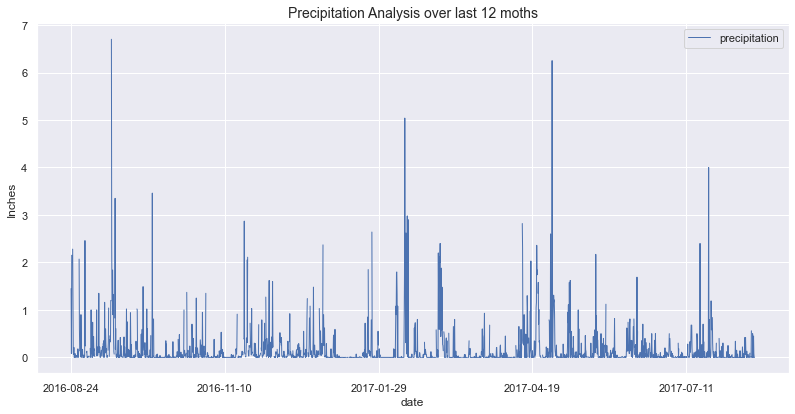

In [52]:
# Use Pandas Plotting with Matplotlib to plot the data
data.set_index('date').plot()
_=plt.title("Precipitation Analysis over last 12 moths", size=14)
_= plt.ylabel('Inches')

In [ ]:
# Alternative query reading to DataFrame
# stmt = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
# df = pd.DataFrame(stmt, columns=["date", "precipitation"])

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,precipitation
count,"2,015.00"
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [61]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stmt = session.query(measurement.station, func.count(measurement.station).label('total_number')).\
                    group_by(measurement.station).order_by(desc('total_number')).statement
data = pd.read_sql_query(stmt, session.bind)
active_station = data['station'][0]
print('Number of unique stations: ', len(data))
data

Number of unique stations:  9


,station,total_number
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stmt = session.query(measurement.station, station.name, func.min(measurement.prcp).label('min_prcp'),
                    func.max(measurement.prcp).label('max_prcp'), func.avg(measurement.prcp).label('avg_prcp')).\
                    filter(measurement.station == station.station).\
                    group_by(measurement.station).filter(measurement.station == active_station).statement
data = pd.read_sql_query(stmt, session.bind)
data

,station,name,min_prcp,max_prcp,avg_prcp
0,USC00519281,"WAIHEE 837.5, HI US",0.00,9.64,0.21


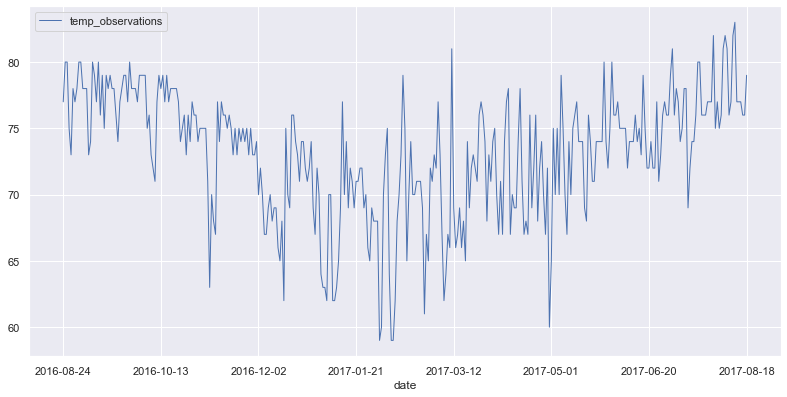

In [80]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(func.date(measurement.date).label('date'), measurement.tobs.label('temp_observations')).\
                    filter(measurement.date > year_ago).filter(measurement.station == active_station).\
                    order_by(measurement.tobs.desc()).statement
data = pd.read_sql_query(stmt, session.bind)
data = data.sort_values('date')
data.set_index('date').plot()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
